# Overview

In this notebook, I will use the dataset to fine-tune a Resnet18 model with added classification heads for 5 different tasks.

Resnet18 is a fast model that is a good canidate to establish an initial baseline.

In [1]:
%load_ext autoreload
%autoreload 2

RANDOM_STATE = 2025

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import os
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image

In [3]:
dataset_dir = "../data/cloth_dataset"
csv_file_name = "aarong_dataset_clean_final.csv"

# Load CSV File
csv_file = os.path.join(dataset_dir, csv_file_name)
df = pd.read_csv(csv_file)

df.sample(3)

,product_id,annotated_image_name,fabric_types_clean,wear_types_clean,colors_clean,textures_clean,value_additions_clean
2447,2410,1420000176657_2.jpg,Viscose Blend,Shalwar Kameez,"grey,blue,pink,green","embroidery,printed,textured",NaN
2341,7646,0470000103648.jpg,Silk,Scarves,"black,yellow,white,green",hand paint,NaN
2428,3494,0660000104616.jpg,Viscose,Shawls,"red,golden",screen print,fringe


In [4]:
single_label_features = ['fabric_types_clean', 'wear_types_clean']
multilabel_features = ['colors_clean', 'textures_clean', 'value_additions_clean']

Let's repeat the preprcessing steps to remove NaN values and removing rare labels, as was done in the `training_dataset_review.ipynb` notebook. I will avoid elaborate description for these steps as they are already described in the other notebook.

In [5]:
from my_utils.dataset_utils import remove_rare_labels

for column in single_label_features + multilabel_features:
	# Replace NaN values with empty strings
	df[column] = df[column].fillna('')

	# Remove rare labels
	df[column] = remove_rare_labels(df[column], min_samples_threshold=50)

df.sample(3)

,product_id,annotated_image_name,fabric_types_clean,wear_types_clean,colors_clean,textures_clean,value_additions_clean
3002,2401,1420000176874_2_1.jpg,Cotton,Shalwar Kameez,"white,green","embroidery,printed",
1365,1375,0550000146047_1.jpg,Muslin,Saree,"brown,white",,tangail
2913,6357,1190000011353.jpg,Cotton,Kurta,"red,green","embroidery,printed,textured",


Now let's encode the feature labels into one-hot format. For the multi-label features, I will use MultiLabelBinarizer from sklearn, which essentially is a one-hot encoding for multiple labels.

I have implemented two utility functions to do the onehot and mlb encoding, to make it easy to reuse, will import and use them for encoding.

In [6]:
from my_utils.preprocessing_utils import ml_binarizer, onehot_encode

for column_name in single_label_features:
	df = onehot_encode(df, column_name)

for column_name in multilabel_features:
	df = ml_binarizer(df, column_name)

df.sample(3)

,product_id,annotated_image_name,fabric_types_clean,wear_types_clean,colors_clean,textures_clean,value_additions_clean,fabric_types_clean__Cotton,fabric_types_clean__Linen,fabric_types_clean__Muslin,...,textures_clean__wax dye,value_additions_clean__,value_additions_clean__applique,value_additions_clean__fringe,value_additions_clean__handloom,value_additions_clean__lace,value_additions_clean__nakshi,value_additions_clean__sequins,value_additions_clean__tangail,value_additions_clean__tassels
1815,2711,1420000178235.jpg,Voile,Shalwar Kameez,"blue,green","embroidery,printed,textured",tassels,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
311,7257,0570000117720_2.jpg,Viscose,Panjabi,"red,brown,black","block print,textured",,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,0,0
2782,2848,1420000169855.jpg,Viscose Blend,Shalwar Kameez,"orange,pink,cyan","embroidery,printed",,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,0,0


At this point, let's create a Train/Validation/Test Split. 70% of the data will be used for training, 15% for validation, and 15% for testing.

In [7]:
from sklearn.model_selection import train_test_split

train_df, val_test_df = train_test_split(df, test_size=0.3, random_state=RANDOM_STATE)
val_df, test_df = train_test_split(val_test_df, test_size=0.5, random_state=RANDOM_STATE)


Now let's create a custom dataset that will use the dataframes above and load respective images.

As a first step, I will define a transform function that will be used to preprocess the images.

In [8]:
# Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


Now let's define the custom dataset class. This will identify the one-hot encoded label columns, separately for each feature, based on the column prefix. The images will be loaded based on the image file name available in the dataframe.

In [9]:
from torch.utils.data import Dataset
from PIL import Image
import torch

class CustomMTLDataset(Dataset):
	def __init__(self, df, image_dir, transform=None):
		self.df = df.reset_index(drop=True)
		self.image_dir = image_dir
		self.transform = transform

		# Specifying label groups for each classification head
		self.label_columns = {
			'fabric': [col for col in df.columns if col.startswith('fabric_types_clean__')],
			'wear': [col for col in df.columns if col.startswith('wear_types_clean__')],
			'color': [col for col in df.columns if col.startswith('colors_clean__')],
			'texture': [col for col in df.columns if col.startswith('textures_clean__')],
			'value_add': [col for col in df.columns if col.startswith('value_additions_clean__')],
		}

	def __len__(self):
		return len(self.df)

	def __getitem__(self, idx):
		row = self.df.iloc[idx]
		
		image_path = f"{self.image_dir}/{row['annotated_image_name']}"
		image = Image.open(image_path).convert("RGB")
		
		if self.transform:
			image = self.transform(image)

		# Extract labels for each separate task
		labels = {
			task: torch.tensor(row[self.label_columns[task]].values.astype('float32'))
			for task in self.label_columns
		}

		return image, labels


At this point, let's create the data loader using the custom dataset that was just defined. For now, I will use a batch size of 8 as some labels may have very few samples. Will later experiment with larger batch sizes if make sense.



In [10]:
from torch.utils.data import DataLoader

train_ds = CustomMTLDataset(train_df, os.path.join(dataset_dir, 'images'), transform=transform)
val_ds = CustomMTLDataset(val_df, os.path.join(dataset_dir, 'images'), transform=transform)
test_ds = CustomMTLDataset(test_df, os.path.join(dataset_dir, 'images'), transform=transform)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True) 
test_loader = DataLoader(test_ds, batch_size=8, shuffle=False)
val_loader = DataLoader(val_ds, batch_size=8, shuffle=False)

Now time to build the model. I will use a pre-trained ResNet (resnet 18) model and add a single layer for each (task) classification head on top of it.

I would not freeze backbone weights so they should be trained as well, i.e.- fine-tuning as opposed to feature extraction.

In [18]:
import torch.nn as nn
import torchvision.models as models

class MTLModel(nn.Module):
    def __init__(self, fabric_dim, wear_dim, color_dim, texture_dim, value_add_dim):
        super(MTLModel, self).__init__()
        self.backbone = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        self.backbone.fc = nn.Identity()
        self.shared_dim = 512  # Output of resnet18 without FC

        self.heads = nn.ModuleDict({
            'fabric': nn.Linear(self.shared_dim, fabric_dim),
            'wear': nn.Linear(self.shared_dim, wear_dim),
            'color': nn.Linear(self.shared_dim, color_dim),
            'texture': nn.Linear(self.shared_dim, texture_dim),
            'value_add': nn.Linear(self.shared_dim, value_add_dim),
        })

    def forward(self, x):
        features = self.backbone(x)
        return {task: head(features) for task, head in self.heads.items()}


Now let's train the model.

I will use a relatively simple training setup with no learning rate scheduling, class weight consideration or focal loss etc. I will later experiment with these techniques if time permits.

For calculating the training loss, I will use **_binary cross-entropy with logits_** for all tasks, for now. In a later experiment, I will try with separate loss functions for single-label and multi-label tasks.

For evaluation, I will collect the four common metrics (`accuracy`, `precision`, `recall`, `f1`) for all tasks initially. However, in later experiments, I will primarily focus on `F1 score` and `precision` for multi-label tasks, and `accuracy` for single-label tasks.

In [19]:
import torch
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from tqdm import tqdm
import json
import os

def run_epoch(model, loader, optimizer, device, is_train=True, threshold=0.5):
	if is_train:
		model.train()
	else:
		model.eval()

	total_loss = 0.0
	all_preds = {k: [] for k in model.heads}
	all_targets = {k: [] for k in model.heads}

	for images, labels in tqdm(loader):
		images = images.to(device)
		labels = {k: v.to(device) for k, v in labels.items()}

		if is_train:
			optimizer.zero_grad()

		with torch.set_grad_enabled(is_train):
			outputs = model(images)
			losses = []

			for task in outputs:
				loss = torch.nn.functional.binary_cross_entropy_with_logits(outputs[task], labels[task])
				losses.append(loss)

				if not is_train:
					probs = torch.sigmoid(outputs[task])
					preds = (probs > threshold).int()
					all_preds[task].extend(preds.cpu().numpy())
					all_targets[task].extend(labels[task].cpu().numpy())

			batch_loss = sum(losses)
			total_loss += batch_loss.item()

			if is_train:
				batch_loss.backward()
				optimizer.step()

	avg_loss = total_loss / len(loader)

	if not is_train:
		metrics = {
			task: {
				'f1': f1_score(all_targets[task], all_preds[task], average='micro', zero_division=0),
				'precision': precision_score(all_targets[task], all_preds[task], average='micro', zero_division=0),
				'recall': recall_score(all_targets[task], all_preds[task], average='micro', zero_division=0),
				'accuracy': accuracy_score(all_targets[task], all_preds[task])
			}
			for task in all_preds
		}
		return avg_loss, metrics
	else:
		return avg_loss


def train_model(model, train_loader, val_loader, optimizer, device, num_epochs=10, threshold=0.5, verbose=True):
	model.to(device)
	best_val_loss = float('inf')
	patience = 3
	patience_counter = 0

	timestamp = pd.Timestamp.now().strftime("%Y%m%d-%H%M%S")
	best_model_path = os.path.join('../data', 'model_weights', f'best_model-resnet18-{timestamp}.pt')
	history_path = os.path.join('../data', 'model_weights', f'history-resnet18-{timestamp}.json')

	history = {
		'train_loss': [],
		'val_loss': [],
		'val_metrics': []
	}

	for epoch in range(num_epochs):
		print(f"\nEpoch {epoch+1}/{num_epochs}")
		train_loss = run_epoch(model, train_loader, optimizer, device, is_train=True)
		val_loss, val_metrics = run_epoch(model, val_loader, optimizer, device, is_train=False, threshold=threshold)

		history['train_loss'].append(train_loss)
		history['val_loss'].append(val_loss)
		history['val_metrics'].append(val_metrics)

		print(f"Train Loss: {train_loss:.4f}")
		print(f"Val Loss: {val_loss:.4f}")

		if verbose:
			for task, task_metrics in val_metrics.items():
				print("Metrics for task:", task)
				for metric_name, metric_value in task_metrics.items():
					print(f"\t[Val {metric_name}]: {metric_value:.4f}")

		# Early stopping
		if val_loss < best_val_loss:
			best_val_loss = val_loss
			patience_counter = 0
			torch.save(model.state_dict(), best_model_path)
		else:
			patience_counter += 1
			if patience_counter >= patience:
				print("Early stopping triggered.")
				break

	# Save the training history
	with open(history_path, 'w') as f:
		json.dump(history, f)

	return history


In [20]:
model = MTLModel(
	fabric_dim=len(train_ds.label_columns['fabric']),
	wear_dim=len(train_ds.label_columns['wear']),
	color_dim=len(train_ds.label_columns['color']),
	texture_dim=len(train_ds.label_columns['texture']),
	value_add_dim=len(train_ds.label_columns['value_add']),
)

for param in model.backbone.parameters():
	param.requires_grad = True

optimizer = optim.Adam(model.parameters(), lr=0.001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [21]:
history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    device=device,
    num_epochs=10,
    threshold=0.5,
	verbose=False
)



Epoch 1/10


  0%|          | 0/289 [00:00<?, ?it/s]

100%|██████████| 62/62 [00:03<00:00, 17.86it/s]


Train Loss: 1.4599
Val Loss: 1.2790

Epoch 2/10


100%|██████████| 62/62 [00:03<00:00, 18.05it/s]


Train Loss: 1.2910
Val Loss: 1.2446

Epoch 3/10


100%|██████████| 62/62 [00:03<00:00, 17.79it/s]


Train Loss: 1.2144
Val Loss: 1.1843

Epoch 4/10


100%|██████████| 62/62 [00:03<00:00, 17.74it/s]


Train Loss: 1.1653
Val Loss: 1.1464

Epoch 5/10


100%|██████████| 62/62 [00:03<00:00, 17.95it/s]


Train Loss: 1.1083
Val Loss: 1.1446

Epoch 6/10


100%|██████████| 62/62 [00:03<00:00, 18.04it/s]


Train Loss: 1.0531
Val Loss: 1.1444

Epoch 7/10


100%|██████████| 62/62 [00:03<00:00, 17.77it/s]


Train Loss: 1.0037
Val Loss: 1.1304

Epoch 8/10


100%|██████████| 62/62 [00:03<00:00, 18.02it/s]


Train Loss: 0.9493
Val Loss: 1.1052

Epoch 9/10


100%|██████████| 62/62 [00:03<00:00, 18.03it/s]


Train Loss: 0.8793
Val Loss: 1.1467

Epoch 10/10


100%|██████████| 62/62 [00:03<00:00, 17.86it/s]


Train Loss: 0.8007
Val Loss: 1.2287


Let's plot the training and validation loss first. And then look at the evaluation metrics for each task.

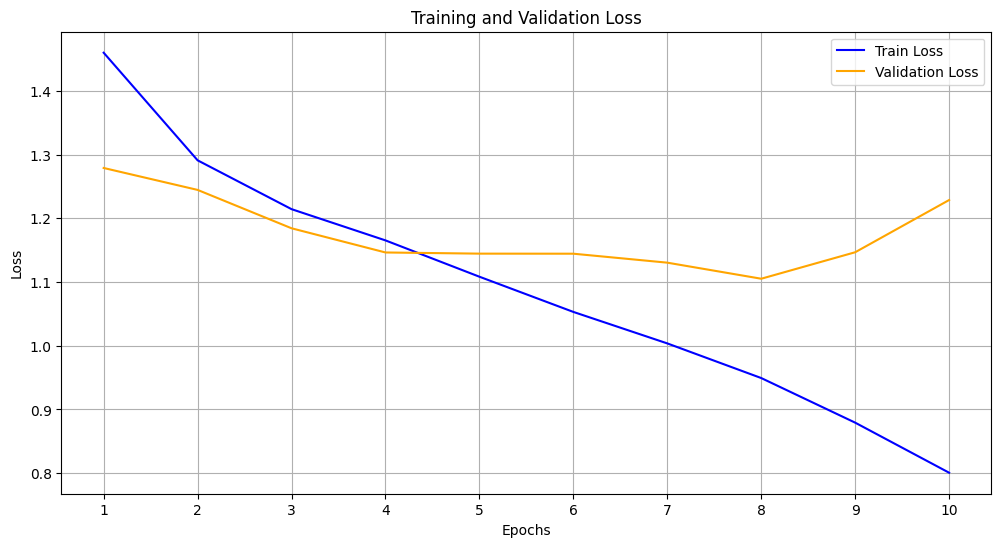

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(history['train_loss'], label='Train Loss', color='blue')
plt.plot(history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.xticks(ticks=range(len(history['train_loss'])), labels=range(1, len(history['train_loss']) + 1))

plt.show()


Looks like model started to overfit after epoch 8. Let's also look at some of the task specific metrics.

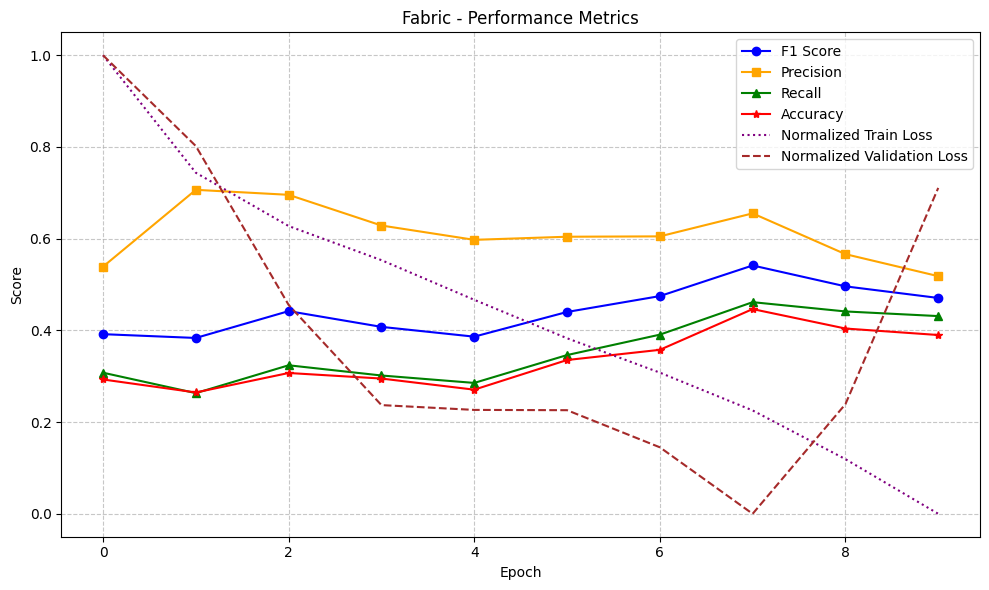

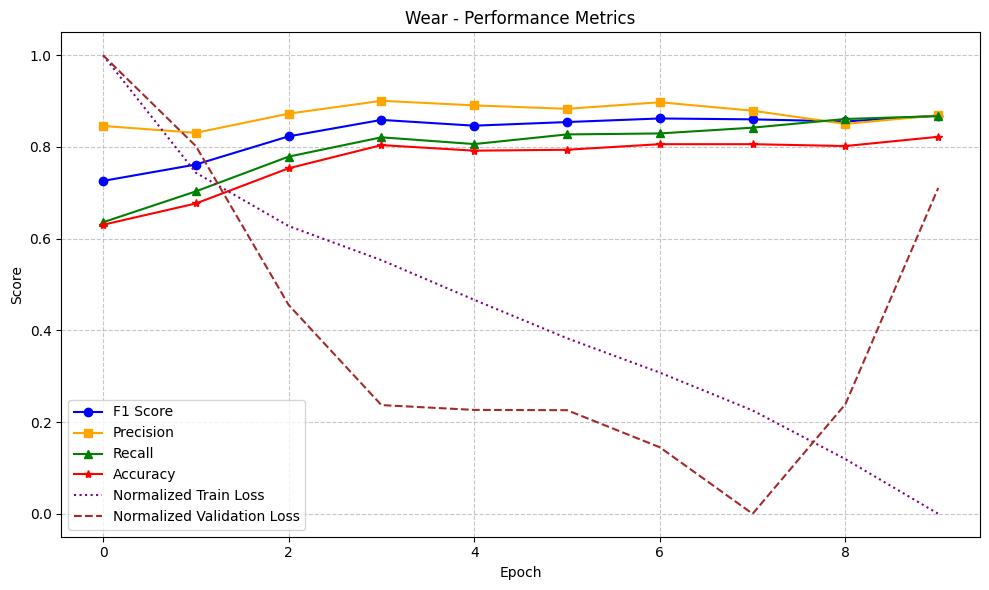

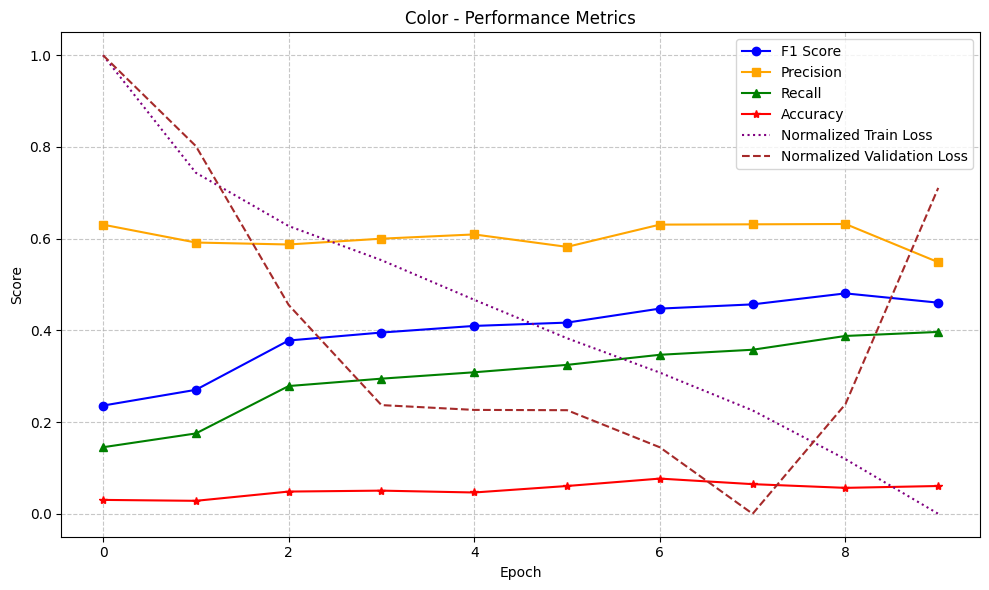

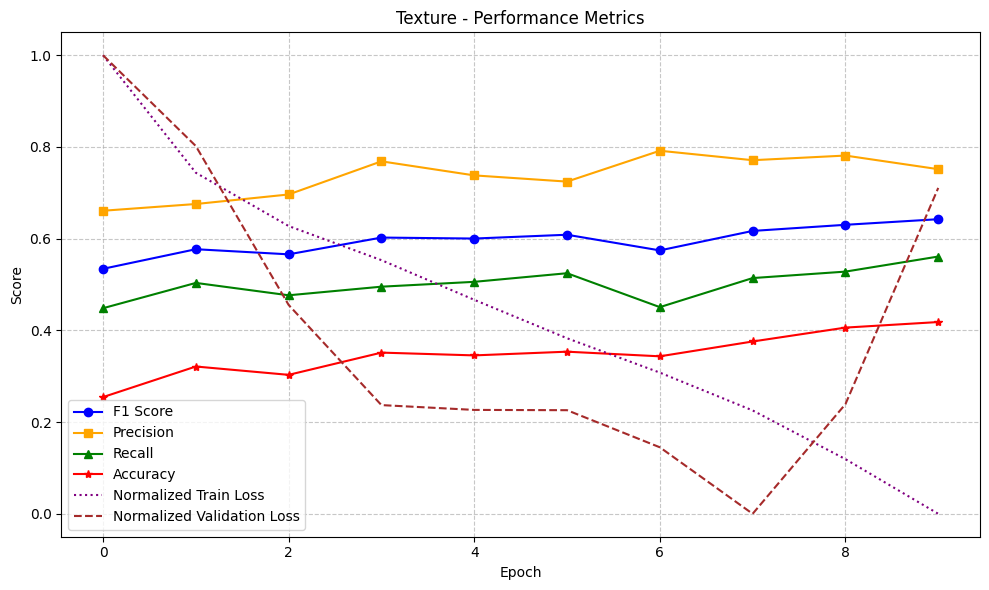

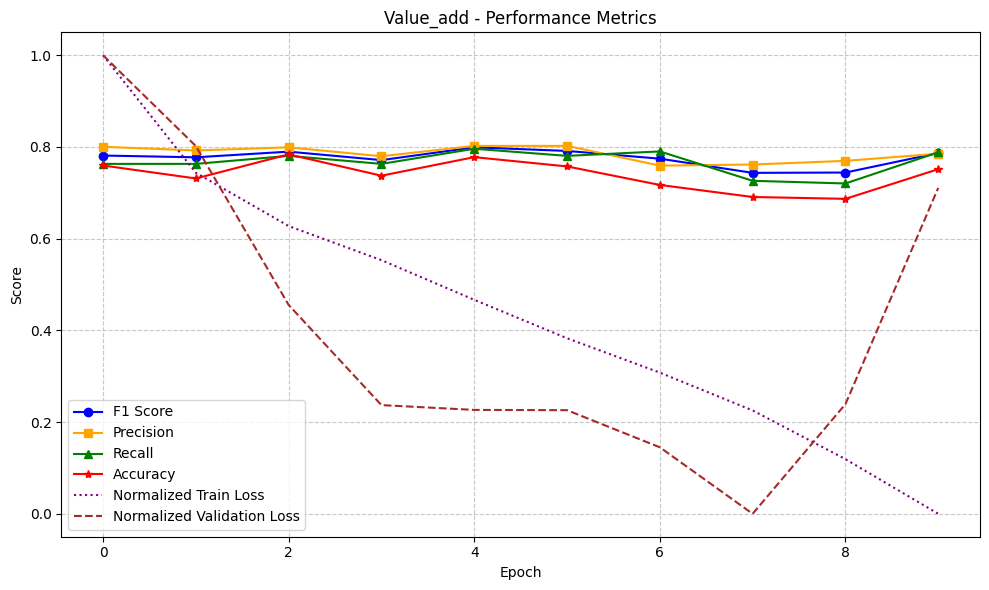

In [28]:
def plot_metrics_for_task(history, task, show_metrics=['f1', 'precision', 'recall', 'accuracy'], show_losses=False):
	# Extract metrics for the specified task
	f1_scores = [epoch_metrics[task]['f1'] for epoch_metrics in history['val_metrics']]
	precision_scores = [epoch_metrics[task]['precision'] for epoch_metrics in history['val_metrics']]
	recall_scores = [epoch_metrics[task]['recall'] for epoch_metrics in history['val_metrics']]
	accuracy_scores = [epoch_metrics[task]['accuracy'] for epoch_metrics in history['val_metrics']]
	
	# Create figure
	plt.figure(figsize=(10, 6))
	
	# Plot the metrics
	if 'f1' in show_metrics:
		plt.plot(f1_scores, label='F1 Score', color='blue', marker='o')
	
	if 'precision' in show_metrics:
		plt.plot(precision_scores, label='Precision', color='orange', marker='s')
	
	if 'recall' in show_metrics:
		plt.plot(recall_scores, label='Recall', color='green', marker='^')
	
	if 'accuracy' in show_metrics:
		plt.plot(accuracy_scores, label='Accuracy', color='red', marker='*')

	if show_losses:
		normalized_train_loss = [(loss - min(history['train_loss'])) / (max(history['train_loss']) - min(history['train_loss'])) for loss in history['train_loss']]
		plt.plot(normalized_train_loss, label='Normalized Train Loss', color='purple', linestyle=':')

		normalized_val_loss = [(loss - min(history['val_loss'])) / (max(history['val_loss']) - min(history['val_loss'])) for loss in history['val_loss']]
		plt.plot(normalized_val_loss, label='Normalized Validation Loss', color='brown', linestyle='--')
	
	plt.title(f'{task.capitalize()} - Performance Metrics')
	plt.xlabel('Epoch')
	plt.ylabel('Score')
	plt.legend()
	plt.grid(True, linestyle='--', alpha=0.7)
	plt.tight_layout()
	plt.show()

plot_metrics_for_task(history, 'fabric', show_losses=True)
plot_metrics_for_task(history, 'wear', show_losses=True)
plot_metrics_for_task(history, 'color', show_losses=True)
plot_metrics_for_task(history, 'texture', show_losses=True)
plot_metrics_for_task(history, 'value_add', show_losses=True)

Let's also compare the performance of the tasks against a single metric.

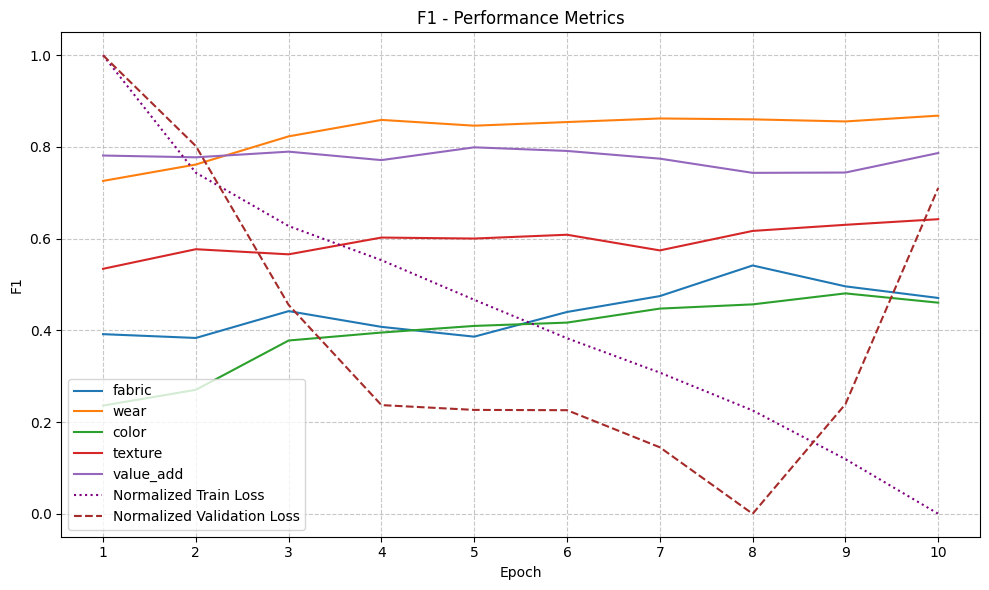

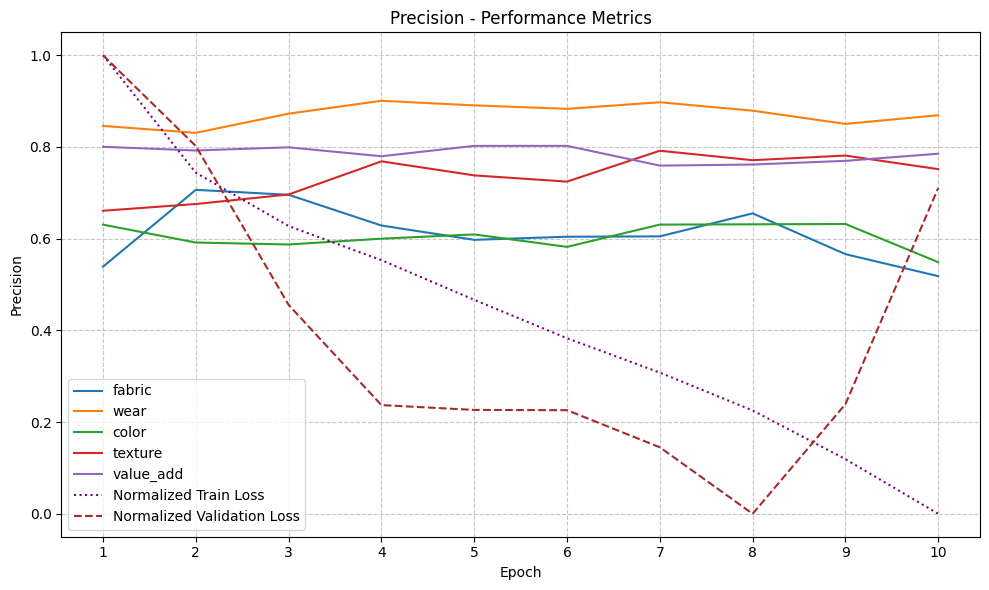

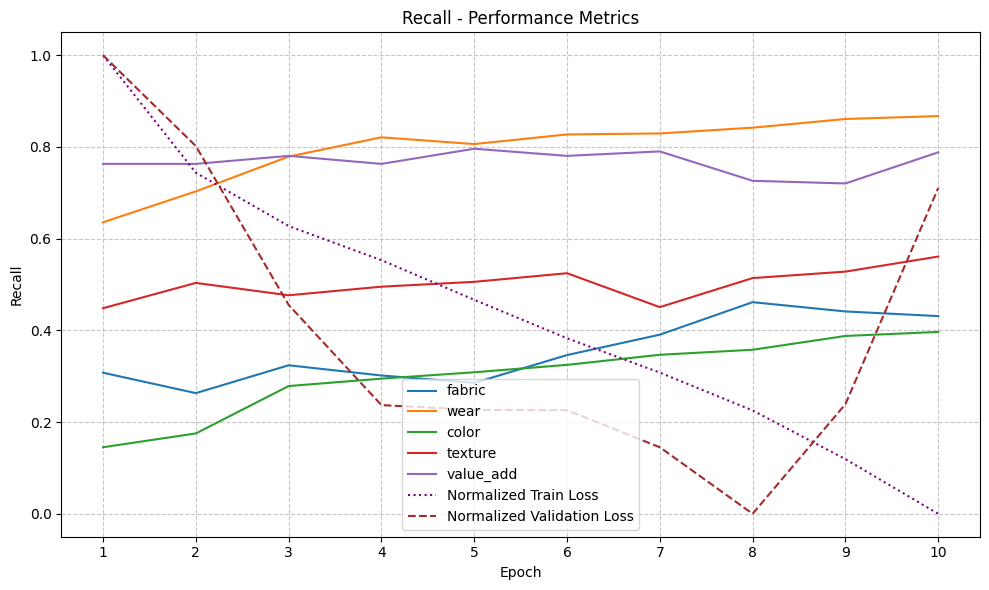

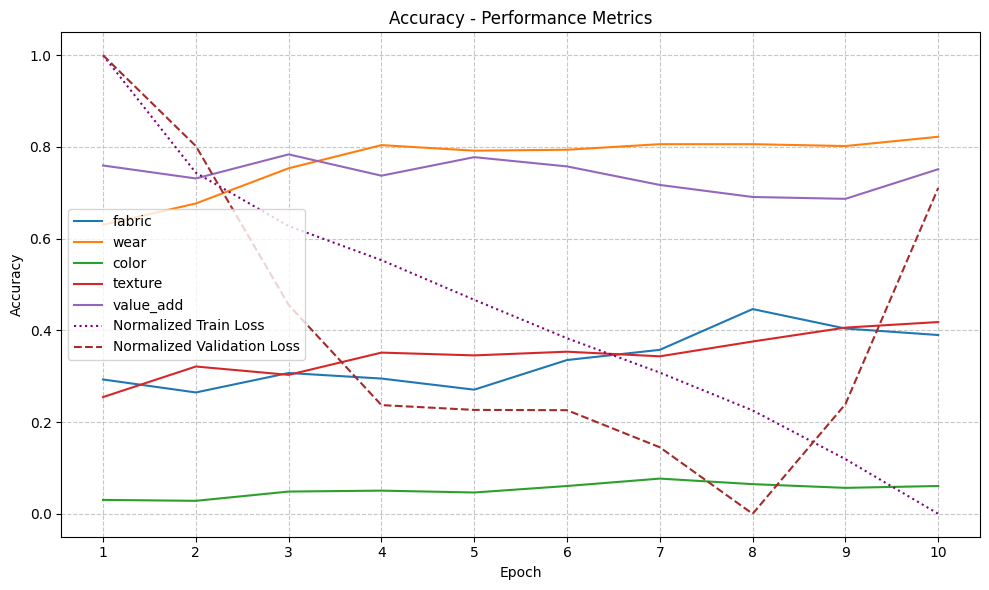

In [29]:
def compare_tasks_for_metric(history, metric_name, show_losses=False):
	plt.figure(figsize=(10, 6))

	tasks = history['val_metrics'][0].keys()

	for task in tasks:
		# Extract specific metric for the task
		metric_scores = [epoch_metrics[task][metric_name] for epoch_metrics in history['val_metrics']]
		plt.plot(metric_scores, label=task)

	if show_losses:
		normalized_train_loss = [(loss - min(history['train_loss'])) / (max(history['train_loss']) - min(history['train_loss'])) for loss in history['train_loss']]
		plt.plot(normalized_train_loss, label='Normalized Train Loss', color='purple', linestyle=':')

		normalized_val_loss = [(loss - min(history['val_loss'])) / (max(history['val_loss']) - min(history['val_loss'])) for loss in history['val_loss']]
		plt.plot(normalized_val_loss, label='Normalized Validation Loss', color='brown', linestyle='--')
	
	plt.title(f'{metric_name.capitalize()} - Performance Metrics')
	plt.xlabel('Epoch')
	plt.ylabel(metric_name.capitalize())
	plt.legend()
	plt.grid(True, linestyle='--', alpha=0.7)

	plt.xticks(ticks=range(len(history['train_loss'])), labels=range(1, len(history['train_loss']) + 1))

	plt.tight_layout()
	plt.show()

compare_tasks_for_metric(history, 'f1', show_losses=True)
compare_tasks_for_metric(history, 'precision', show_losses=True)
compare_tasks_for_metric(history, 'recall', show_losses=True)
compare_tasks_for_metric(history, 'accuracy', show_losses=True)

Let's take the metrics of best epoch to set up a baseline. Model started to overfit after epoch 8, so will use epoch 8 metrics for the baseline.

In [46]:
import pandas as pd
import numpy as np

best_epoch = 8 - 1

metrics = history['val_metrics'][best_epoch]

pd.DataFrame.from_dict(metrics, orient='index').T.round(2)

,fabric,wear,color,texture,value_add
f1,0.54,0.86,0.46,0.62,0.74
precision,0.66,0.88,0.63,0.77,0.76
recall,0.46,0.84,0.36,0.51,0.73
accuracy,0.45,0.81,0.06,0.38,0.69


Looks like the wear and value addition did well, and the color classification performance seem to be terrible. There could be several reasons behind this, starting with the fact that this is a multi-label task, and each image usually had several colors even including the minor amount of colors in the cloth. Also the color set was reduced down to a limited number of colors through brute generalization rules. In addition, color annotation is often subjective (e.g.- cyan vs blue, yellow vs golden, pink vs red etc.), which is making it a very difficult task.

In later experiments I will try to improve this as well as the rest of the tasks, by attempting to use different models, hyperparameter tuning, and other techniques such as class weight consideration etc.

This is end of initial experiments. Addional experiments will be done in separate notebook so that the experiments are cleaner and easy to follow, most pre-processing and utility functions will be moved to a separate module and reused in the rest of the notebooks.